# Implement and test image reader

## Imports and configuration

In [1]:
!ln -s ./../lung_cancer_detection

ln: ./lung_cancer_detection: File exists


In [31]:
from pathlib import Path

import numpy as np
import pandas as pd
from monai.config import print_config
from monai.transforms import LoadImage, LoadImaged, AddChanneld, Spacingd, RandAffined
from monai.data.image_reader import NumpyReader, ImageReader, ITKReader
from lung_cancer_detection.data.image_reader import LIDCReader
from PIL import Image
from matplotlib import cm

pd.set_option('display.max_columns', None)

DATA_DIR = Path("/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/processed")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
print_config()

MONAI version: 0.4.0
Numpy version: 1.19.4
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0563a4467fa602feca92d91c7f47261868d171a1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.0
Pillow version: 8.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.8.2
ITK version: 5.1.2
tqdm version: 4.56.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Specify requirements

In [5]:
?LoadImage

Loading an image requires an `monai.data.image_reader.ImageReader` object at runtime.

In [6]:
??NumpyReader

The default `NumpyReader` does not work for our use case because we want to support the `monai` transformations which relies on metadata from medical images such as orientation.

In [7]:
??ImageReader

In order to create our own `ImageReader`, we have to implement three methods:

- `verify_suffix`: takes a list of filenames and returns a boolean which states whether the file names are supported
- `read`: Read raw image data from specified file(s)
- `get_data`: Extracts data array and meta data from loaded image and returns them

Several particularities of our dataset have to be considered:

- The filename is always a patient ID
- Loading image and mask requires separate calls to the `ImageReader` class
- In addition to reading data from the `npy` files, we need to extract metadata from the dataframe

## Initialize image reader

In [8]:
reader = LIDCReader(DATA_DIR)

## Test verify_suffix method

In [9]:
filename = "images/unknown.npy"
reader.verify_suffix(filename)

True

## Test read method

In [10]:
img, meta = reader.read("images/LIDC-IDRI-0133.npy")
print(img.shape)
print(type(meta))

(512, 512, 238)
<class 'pandas.core.series.Series'>


In [11]:
meta

StudyID                    1.3.6.1.4.1.14519.5.2.1.6279.6001.138751917514...
SeriesID                   1.3.6.1.4.1.14519.5.2.1.6279.6001.133378195429...
SliceThickness                                                      1.250000
SliceSpacing                                                        1.250000
PixelSpacing                                                        0.742188
ContrastUsed                                                            True
ImagePositionPatient                 [-190.000000, -190.000000, -303.500000]
ImageOrientationPatient    [1.000000, 0.000000, 0.000000, 0.000000, 1.000...
Rows                                                                     512
Columns                                                                  512
RescaleIntercept                                                -1024.000000
RescaleSlope                                                        1.000000
WindowCenter                                                            -600

In [12]:
meta.ImagePositionPatient

'[-190.000000, -190.000000, -303.500000]'

## Test get_data method

In [13]:
img_array, img_meta = reader.get_data((img, meta))

In [14]:
print(img_array.shape)
print(img_meta)

(512, 512, 238)
{'origin': array([-190. , -190. , -303.5]), 'spacing': array([0.742188, 0.742188, 1.25    ]), 'direction': array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), 'original_affine': array([[   0.742188,    0.      ,    0.      , -190.      ],
       [   0.      ,    0.742188,    0.      , -190.      ],
       [   0.      ,    0.      ,    1.25    , -303.5     ],
       [   0.      ,    0.      ,    0.      ,    1.      ]]), 'affine': array([[   0.742188,    0.      ,    0.      , -190.      ],
       [   0.      ,    0.742188,    0.      , -190.      ],
       [   0.      ,    0.      ,    1.25    , -303.5     ],
       [   0.      ,    0.      ,    0.      ,    1.      ]]), 'spatial_shape': array([512, 512, 238])}


## Test image transformations

### Loading with dictionary-based wrapper

In [15]:
data_dict = {"image": "images/LIDC-IDRI-0186.npy", "label": "masks/LIDC-IDRI-0186.npy"}

In [16]:
loader = LoadImaged(keys=("image", "label"))
loader.register(LIDCReader(DATA_DIR))

In [17]:
data_dict = loader(data_dict)

In [18]:
data_dict

{'image': array([[[-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         ...,
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.]],
 
        [[-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         ...,
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.]],
 
        [[-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.

In [19]:
def get_img_slice(img, z, window=(-600, 1500)):
    # clip pixel values to desired window
    level, width = window
    img = np.clip(img, level-(width/2), level+(width/2))
    # normalize pixel values to 0-1 range
    img_min = img.min()
    img_max = img.max()
    img = (img - img_min) / (img_max - img_min)
    # convert to Pillow image for display
    img_slice = img[:, :, z]
    pil_img = Image.fromarray(np.uint8(cm.gray(img_slice)*255))
    return pil_img.convert('RGBA')

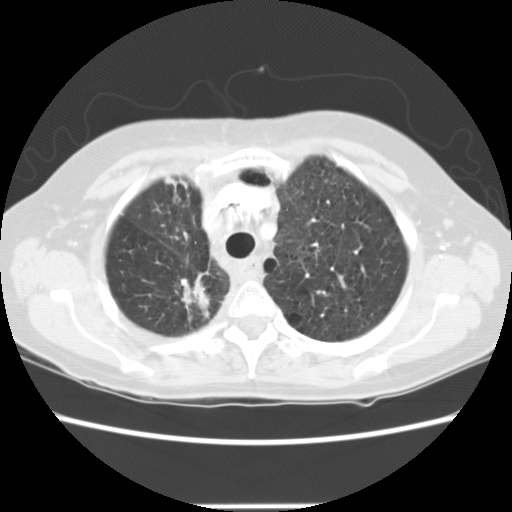

In [20]:
get_img_slice(data_dict["image"], 112)

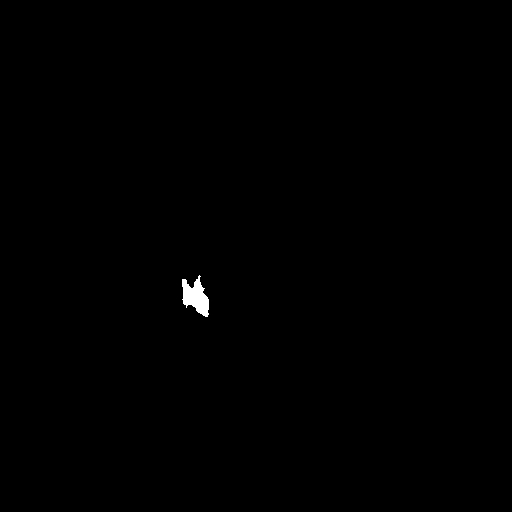

In [21]:
get_img_slice(data_dict["label"], 112)

### Add channel dimension

In [22]:
add_channel = AddChanneld(keys=["image", "label"])
data_dict = add_channel(data_dict)
data_dict["image"].shape

(1, 512, 512, 137)

### Resample to consistent voxel size

In [23]:
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image affine before Spacing:\n{data_dict['image_meta_dict']['affine']}")
print(f"label affine before Spacing:\n{data_dict['label_meta_dict']['affine']}")

image shape: (1, 512, 512, 137)
label shape: (1, 512, 512, 137)
image affine before Spacing:
[[   0.644531    0.          0.       -165.      ]
 [   0.          0.644531    0.       -165.      ]
 [   0.          0.          2.5       -20.      ]
 [   0.          0.          0.          1.      ]]
label affine before Spacing:
[[   0.644531    0.          0.       -165.      ]
 [   0.          0.644531    0.       -165.      ]
 [   0.          0.          2.5       -20.      ]
 [   0.          0.          0.          1.      ]]


In [24]:
spacing = Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest"))
data_dict = spacing(data_dict)

In [30]:
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image affine after Spacing:\n{data_dict['image_meta_dict']['affine']}")
print(f"label affine after Spacing:\n{data_dict['label_meta_dict']['affine']}")
print(f"image original affine after Spacing:\n{data_dict['image_meta_dict']['original_affine']}")
print(f"label original affine after Spacing:\n{data_dict['label_meta_dict']['original_affine']}")

image shape: (1, 330, 330, 341)
label shape: (1, 330, 330, 341)
image affine after Spacing:
[[   1.    0.    0. -165.]
 [   0.    1.    0. -165.]
 [   0.    0.    1.  -20.]
 [   0.    0.    0.    1.]]
label affine after Spacing:
[[   1.    0.    0. -165.]
 [   0.    1.    0. -165.]
 [   0.    0.    1.  -20.]
 [   0.    0.    0.    1.]]
image original affine after Spacing:
[[   0.644531    0.          0.       -165.      ]
 [   0.          0.644531    0.       -165.      ]
 [   0.          0.          2.5       -20.      ]
 [   0.          0.          0.          1.      ]]
label original affine after Spacing:
[[   0.644531    0.          0.       -165.      ]
 [   0.          0.644531    0.       -165.      ]
 [   0.          0.          2.5       -20.      ]
 [   0.          0.          0.          1.      ]]


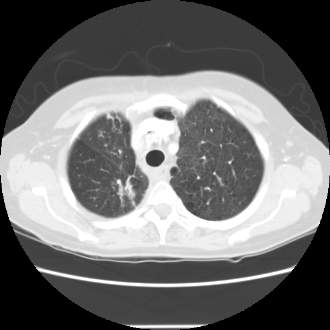

In [28]:
get_img_slice(data_dict["image"][0,:,:,:], 279)

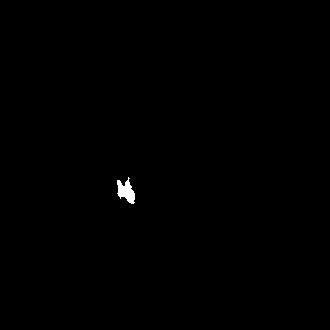

In [29]:
get_img_slice(data_dict["label"][0,:,:,:], 279)

### Random affine transformation

In [42]:
rand_affine = RandAffined(
    keys=["image", "label"],
    mode=("bilinear", "nearest"),
    prob=1.0,
    spatial_size=(300, 300, 300),
    translate_range=(40, 40, 2),
    rotate_range=(np.pi / 36, np.pi / 36, np.pi / 4),
    scale_range=(0.15, 0.15, 0.15),
    padding_mode="border",
)

In [43]:
affine_data_dict = rand_affine(data_dict)

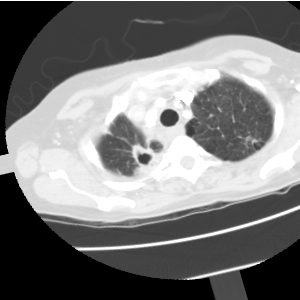

In [47]:
get_img_slice(affine_data_dict["image"][0,:,:,:], 270)

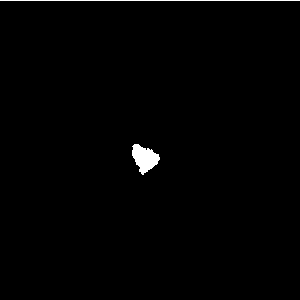

In [49]:
get_img_slice(affine_data_dict["label"][0,:,:,:], 270)